In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

https://towardsdatascience.com/introduction-to-reliability-diagrams-for-probability-calibration-ed785b3f5d44

In [2]:
p = np.array([0.9, 0.2, 0.7, 0.4, 0.8, 0.1, 0.2, 0.8, 0.5, 0.9])

In [3]:
true_labels = np.ones_like(p)
true_labels[[1, 6, 7, 8]] = 0
true_labels

array([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.])

In [4]:
num_splits = 3

In [5]:
splits_arr = np.linspace(0, 1, num_splits + 1)
splits = [(x, y) for (x, y) in zip(splits_arr[:-1], splits_arr[1:])]
splits

[(0.0, 0.3333333333333333),
 (0.3333333333333333, 0.6666666666666666),
 (0.6666666666666666, 1.0)]

In [6]:
pd.cut(pd.Series(p), bins=splits_arr)

0      (0.667, 1.0]
1      (0.0, 0.333]
2      (0.667, 1.0]
3    (0.333, 0.667]
4      (0.667, 1.0]
5      (0.0, 0.333]
6      (0.0, 0.333]
7      (0.667, 1.0]
8    (0.333, 0.667]
9      (0.667, 1.0]
dtype: category
Categories (3, interval[float64, right]): [(0.0, 0.333] < (0.333, 0.667] < (0.667, 1.0]]

In [35]:
splits = np.digitize(p, splits_arr)
splits

array([3, 1, 3, 2, 3, 1, 1, 3, 2, 3])

In [9]:
p_group = {}
labels_pos = {}
for group in np.unique(splits):
    p_group[group] = p[splits==group]
    #frac_pos[group] = true_labels[splits==group].sum()*1.0/len(p_group[group])
    labels_pos[group] = true_labels[splits==group]
    #print(np.arange(10)[splits==group])

In [10]:
p_group

{1: array([0.2, 0.1, 0.2]),
 2: array([0.4, 0.5]),
 3: array([0.9, 0.7, 0.8, 0.8, 0.9])}

In [11]:
labels_pos

{1: array([0., 1., 0.]), 2: array([1., 0.]), 3: array([1., 1., 1., 0., 1.])}

In [12]:
p_group_mean = {k:np.mean(v) for k, v in p_group.items()}
p_group_mean

{1: 0.16666666666666666, 2: 0.45, 3: 0.8200000000000001}

In [13]:
fracs = {k:np.sum(v)*1.0/len(v) for k, v in labels_pos.items()}
fracs

{1: 0.3333333333333333, 2: 0.5, 3: 0.8}

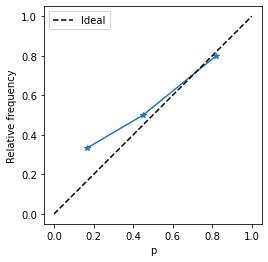

In [14]:
plt.plot(p_group_mean.values(), fracs.values(), marker='*')
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.gca().set_aspect("equal")
plt.xlabel("p")
plt.ylabel("Relative frequency")

plt.plot([0, 1], [0, 1], color='k', ls='--', label='Ideal')
plt.legend()

Let us wrap into a function



In [15]:
def calib_curve(true, pred, n_bins = 10):
    splits_arr = np.linspace(0, 1, n_bins + 1)
    splits = np.digitize(pred, splits_arr)
    p_group = {}
    labels_pos = {}
    for group in np.unique(splits):
        p_group[group] = pred[splits==group]
        labels_pos[group] = true[splits==group]
    p_group_mean = {k:np.mean(v) for k, v in p_group.items()}
    fracs = {k:np.sum(v)*1.0/len(v) for k, v in labels_pos.items()}
    counts = np.array([len(v) for v in labels_pos.values()])
    return  np.array(list(p_group_mean.values())), np.array(list(fracs.values())), counts

In [16]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

prob_true, prob_pred = calibration_curve(true_labels, p, n_bins=3)

In [17]:
prob_true

array([0.33333333, 0.5       , 0.8       ])

In [18]:
prob_pred

array([0.16666667, 0.45      , 0.82      ])

In [19]:
p_ours, p_hat_ours, count = calib_curve(true_labels, p, 3)
p_ours

array([0.16666667, 0.45      , 0.82      ])

Expected Calibration Error

In [20]:
(np.abs(p_ours-p_hat_ours)*count).mean()

0.23333333333333336

In [21]:
from sklearn.datasets import make_classification

In [22]:
X, y = make_classification(n_features=2, n_informative=2, n_redundant=0, random_state=0)

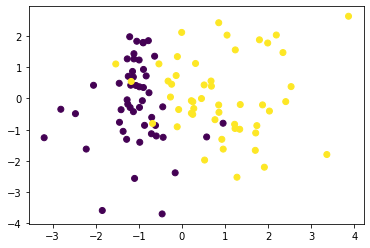

In [23]:
plt.scatter(X[:, 0], X[:, 1], c = y)

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
lr = LogisticRegression()

In [26]:
lr.fit(X, y)

LogisticRegression()

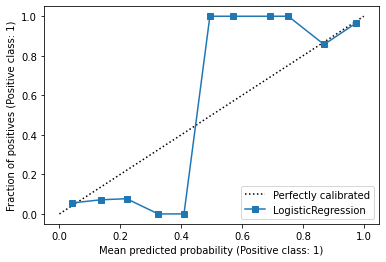

In [27]:
display = CalibrationDisplay.from_estimator(
        lr,
        X,
        y,
        n_bins=11,
)

In [28]:
pred_p = lr.predict_proba(X)[:, 1]

In [29]:
probs, fractions, counts  = calib_curve(y, pred_p, 11)

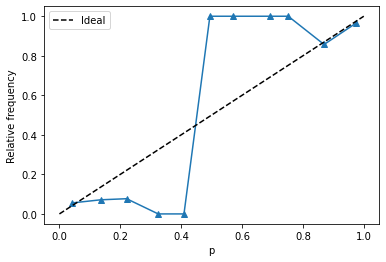

In [30]:
plt.plot(probs, fractions, marker='^')
plt.xlabel("p")
plt.ylabel("Relative frequency")

plt.plot([0, 1], [0, 1], color='k', ls='--', label='Ideal')
plt.legend()

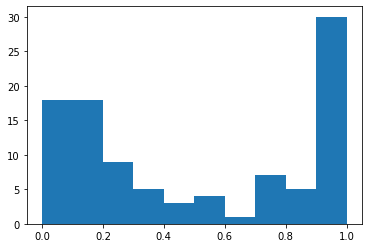

In [31]:
plt.hist(pred_p);

In [32]:
(np.abs(probs-fractions)*counts).mean()

0.9530316314463302

In [33]:
counts

array([18, 14, 13,  4,  2,  4,  2,  2,  6,  7, 28])